In [1]:
import os
os.chdir(r"C:\Users\gram\Desktop\prj 1\data13")

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train['date2'] = pd.to_datetime(train['date'])

In [4]:
train['weekday'] = train['date2'].dt.weekday

In [5]:
train = pd.get_dummies(train,columns=['weekday'])

In [6]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [7]:
del train['date2']
del test['date2']

In [8]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [9]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})

In [10]:
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [11]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

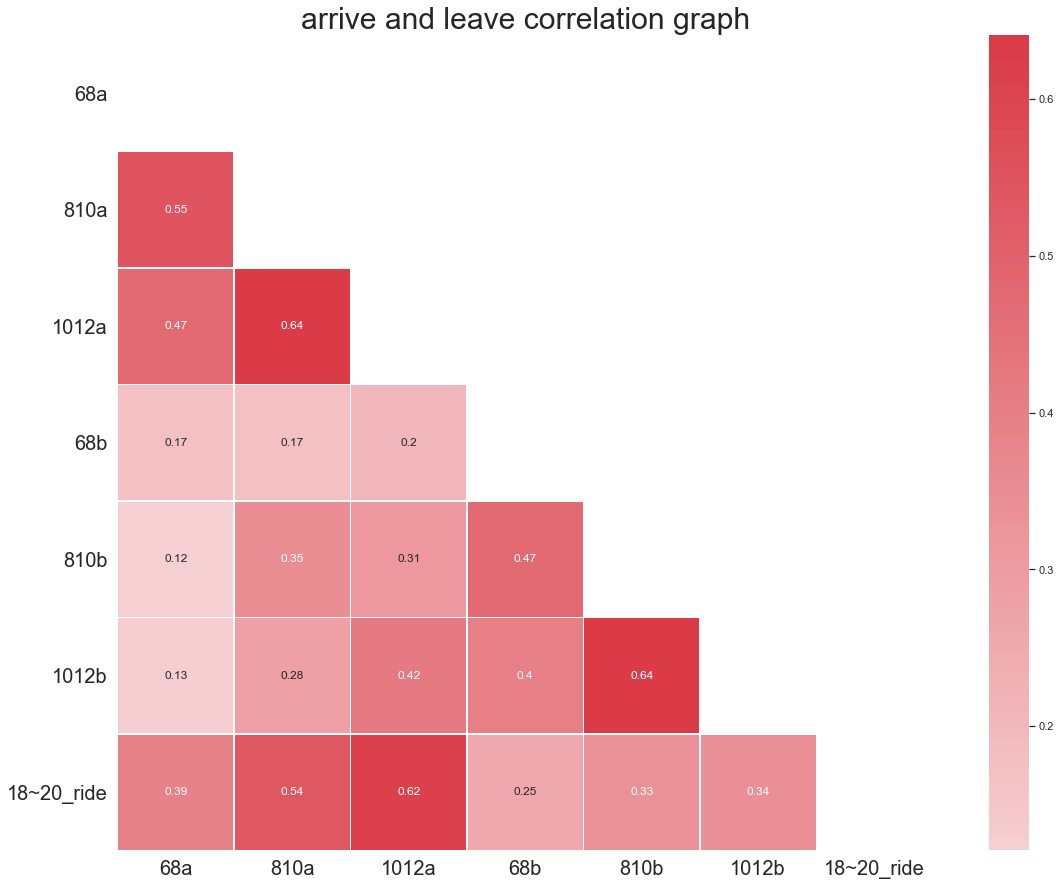

In [12]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train22.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [13]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [14]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [15]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

In [16]:
t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [17]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 3: 828, 1: 659, 2: 597})

In [18]:
t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [19]:
#데이터 불러오기
raining=pd.read_csv("C:\\Users\\gram\\Desktop\\prj 1\\중급\\OBS_ASOS_TIM_20210114113345.csv",engine='python',encoding="cp949")

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['0' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['1' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['2' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['3' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2)
0,0,제주,2019-09-01 01:00,23.7,NaN,2.1,180.0,67,1013.8,1016.2,NaN,NaN
1,0,제주,2019-09-01 02:00,23.5,NaN,1.4,180.0,70,1013.7,1016.1,NaN,NaN
2,0,제주,2019-09-01 03:00,23.4,NaN,1.1,180.0,68,1013.8,1016.2,NaN,NaN
3,0,제주,2019-09-01 04:00,23.4,NaN,1.6,180.0,69,1013.6,1016.0,NaN,NaN
4,0,제주,2019-09-01 05:00,23.3,NaN,1.2,180.0,71,1013.6,1016.0,NaN,NaN


In [20]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

In [21]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

In [22]:
train = train.astype({'dist_name': 'object'})

In [23]:
test = test.astype({'dist_name': 'object'})

In [24]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [25]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2.shape, test2.shape, train.shape, test.shape

((415423, 44), (228170, 43), (415423, 39), (228170, 38))

In [26]:
train2 = train2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})
test2 = test2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})

In [27]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

In [28]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

X_train.shape, y_train.shape

((4154, 26), (4154, 1))

In [29]:
X_train.head()

,in_out,latitude,longitude,68a,810a,1012a,68b,810b,1012b,weekday_0,...,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan
26258,0,33.25409,126.43907,0.0,0.0,0.0,1.0,0.0,0.0,1,...,30.046511,26.109941,43.631735,11.796034,26.145455,0.00,0,0,1,0
273551,0,33.51295,126.52795,3.0,0.0,0.0,0.0,0.0,0.0,0,...,0.206609,41.765298,35.615625,29.793410,23.736364,0.00,0,1,0,0
86821,0,33.30723,126.37999,0.0,0.0,2.0,0.0,0.0,0.0,0,...,26.840113,20.279828,47.390673,18.544731,25.809091,5.02,0,0,1,0
355132,0,33.23592,126.50313,0.0,0.0,0.0,0.0,0.0,2.0,0,...,30.953205,32.350508,38.896236,5.904392,24.863636,0.00,0,0,1,0
102641,0,33.50202,126.50518,0.0,0.0,1.0,0.0,1.0,0.0,0,...,2.642786,39.339629,37.139146,28.923940,23.990909,1.88,0,1,0,0


In [30]:
X_test.head()

,in_out,latitude,longitude,68a,810a,1012a,68b,810b,1012b,weekday_0,...,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan
0,1,33.48990,126.49373,8.0,9.0,10.0,0.0,0.0,1.0,0,...,4.286659,37.692766,37.713630,27.841879,23.009091,2.245455,0,1,0,0
1,1,33.48944,126.48508,7.0,7.0,19.0,0.0,0.0,0.0,0,...,4.966848,37.008492,38.465822,27.996179,23.009091,2.245455,0,1,0,0
2,1,33.48181,126.47352,6.0,4.0,3.0,0.0,0.0,0.0,0,...,6.330746,35.642126,39.259820,27.496551,23.009091,2.245455,0,1,0,0
3,0,33.50577,126.49252,12.0,26.0,46.0,0.0,0.0,0.0,0,...,3.575272,38.643401,38.386802,29.579404,23.009091,2.245455,0,1,0,0
4,0,33.24872,126.41032,0.0,0.0,0.0,0.0,1.0,0.0,0,...,31.460686,23.594010,46.355301,14.445605,22.518182,2.700000,0,0,1,0


In [31]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 2분 ~ 3분 소요

{'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [32]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

((415423, 26), (415423, 1), (228170, 26))

In [33]:
X_test=np.nan_to_num(X_test)

In [35]:
# best_params_를 통해서 나온 값을 투입
rf = RandomForestRegressor(max_features=5,min_samples_leaf=3,min_samples_split=2,n_estimators=100,random_state=1217)

rf.fit(X_train,y_train) #학습 

RandomForestRegressor(max_features=5, min_samples_leaf=3, random_state=1217)

In [36]:
test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("dacon_base_middle2.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

#해당 코드 소요 시간 5분

In [42]:
df = pd.read_csv("C:\\Users\\gram\\Desktop\\prj 1\\중급\\dacon_base_middle2.csv")
df

,id,18~20_ride
0,415423,9.002230
1,415424,9.459058
2,415425,3.271512
3,415426,47.957242
4,415427,0.474509
...,...,...
228165,643588,0.012974
228166,643589,0.021219
228167,643590,0.232739
228168,643591,3.386968


In [47]:
test

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,18~20_ride
0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,...,10.0,0.0,0.0,1.0,4.286659,37.692766,37.713630,27.841879,0,9.002230
1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,...,19.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,9.459058
2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,...,3.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0,3.271512
3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,...,46.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0,47.957242
4,415427,2019-10-01,4270000,0,1636,롯데호텔,33.24872,126.41032,0.0,0.0,...,0.0,0.0,1.0,0.0,31.460686,23.594010,46.355301,14.445605,3,0.474509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,643588,2019-10-16,32820000,0,786,고산환승정류장(고산1리),33.30073,126.18044,0.0,0.0,...,0.0,3.0,0.0,0.0,40.193817,1.810388,65.835199,36.362254,1,0.012974
228166,643589,2019-10-16,32820000,0,1080,애월고등학교,33.46262,126.33447,0.0,0.0,...,0.0,1.0,0.0,0.0,19.020368,24.608845,51.446906,32.217732,0,0.021219
228167,643590,2019-10-16,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,3.0,0.0,...,0.0,0.0,0.0,0.0,27.117280,16.319339,57.465292,33.738981,1,0.232739
228168,643591,2019-10-16,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,3.0,0.0,...,0.0,0.0,0.0,0.0,2.134693,39.904297,36.202951,28.484278,0,3.386968


In [48]:
test.loc[test['18~20_ride'].idxmax()]

id                   633176
date             2019-10-16
bus_route_id       23580000
in_out                    0
station_code            201
station_name          제주대학교
latitude            33.4601
longitude           126.562
6~7_ride                  4
7~8_ride                  3
8~9_ride                  9
9~10_ride                14
10~11_ride                8
11~12_ride               24
6~7_takeoff               0
7~8_takeoff               0
8~9_takeoff               0
9~10_takeoff              6
10~11_takeoff             0
11~12_takeoff             0
weekday_0                 0
weekday_1                 0
weekday_2                 1
weekday_3                 0
weekday_4                 0
weekday_5                 0
weekday_6                 0
68a                       7
810a                     23
1012a                    32
68b                       0
810b                      6
1012b                     0
dis_jeju            6.68578
dis_gosan           41.4428
dis_seongsan        

In [49]:
test.loc[test['18~20_ride'].idxmin()]

id                   416138
date             2019-10-01
bus_route_id       21980000
in_out                    0
station_code           2955
station_name            틀라목
latitude             33.501
longitude           126.677
6~7_ride                  0
7~8_ride                  0
8~9_ride                  0
9~10_ride                 0
10~11_ride                0
11~12_ride                0
6~7_takeoff               1
7~8_takeoff               0
8~9_takeoff               0
9~10_takeoff              0
10~11_takeoff             0
11~12_takeoff             0
weekday_0                 0
weekday_1                 1
weekday_2                 0
weekday_3                 0
weekday_4                 0
weekday_5                 0
weekday_6                 0
68a                       0
810a                      0
1012a                     0
68b                       1
810b                      0
1012b                     0
dis_jeju            13.7609
dis_gosan           53.0624
dis_seongsan        

## 특성 중요도

In [43]:
# 특성 중요도
print("특성 중요도 : \n{}".format(rf.feature_importances_))

특성 중요도 : 
[0.00093775 0.04512273 0.04214872 0.07447668 0.16819139 0.26113053
 0.03356033 0.05052592 0.06103181 0.00436657 0.0034768  0.00346103
 0.00232841 0.00241367 0.00206927 0.00493172 0.04934989 0.04687536
 0.05357048 0.04783711 0.02191499 0.01443147 0.00035598 0.00342429
 0.00159084 0.00047627]


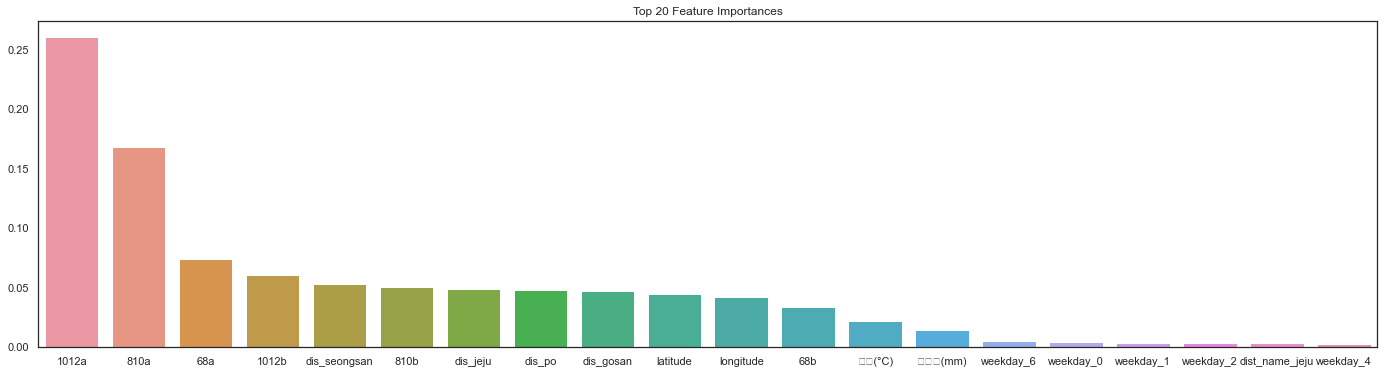

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(24,6))
plt.title('Top 20 Feature Importances')
sns.barplot(y=ftr_top20, x=ftr_top20.index)
plt.show()

In [45]:
ftr_top20

1012a             0.261131
810a              0.168191
68a               0.074477
1012b             0.061032
dis_seongsan      0.053570
810b              0.050526
dis_jeju          0.049350
dis_po            0.047837
dis_gosan         0.046875
latitude          0.045123
longitude         0.042149
68b               0.033560
기온(°C)            0.021915
강수량(mm)           0.014431
weekday_6         0.004932
weekday_0         0.004367
weekday_1         0.003477
weekday_2         0.003461
dist_name_jeju    0.003424
weekday_4         0.002414
dtype: float64

## 결정 트리 그래프

In [40]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.44.1/bin/'

In [41]:
y_train_df = pd.DataFrame(y_train)

In [42]:
train_df = pd.concat([X_train_df,y_train_df],axis=1)
print(train_df)

NameError: name 'X_train_df' is not defined

In [43]:
feature_names = train_df.columns.tolist()

NameError: name 'train_df' is not defined

In [44]:
feature_names = feature_names[0:26]

NameError: name 'feature_names' is not defined

In [45]:
target_name = np.array(['ride No', 'ride Yes'])

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [47]:
dt_clf = DecisionTreeClassifier()

In [48]:
dt_dot_data = tree.export_graphviz(dt_clf, out_file = None,
                                  feature_names = feature_names,
                                  class_names = target_name,
                                  filled = True, rounded = True,
                                  special_characters = True)

NameError: name 'feature_names' is not defined

In [49]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [50]:
import pydot

In [51]:
rf.fit(X_train, y_train)
tree.export_graphviz(rf.estimators_[0], out_file='tree_from_forest.dot')
(graph,) = pydot.graph_from_dot_file('tree_from_forest.dot')
graph.write_png('tree_from_forest.png')

FileNotFoundError: [WinError 2] "dot" not found in path.

In [ ]:
estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = input_var,
                class_names = target,
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )

In [52]:
from sklearn.tree import export_graphviz
from graphviz import Source
Source.from_file("tree.dot")

There is no layout engine support for "dot"
Perhaps "dot -c" needs to be run (with installer's privileges) to register the plugins?


CalledProcessError: Command '['dot', '-Kdot', '-Tsvg']' returned non-zero exit status 1. [stderr: b'There is no layout engine support for "dot"\r\nPerhaps "dot -c" needs to be run (with installer\'s privileges) to register the plugins?\r\n']

## Auto ML

In [53]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [54]:
train = pd.concat([X_train,y_train],axis=1)
train

,in_out,latitude,longitude,68a,810a,1012a,68b,810b,1012b,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jeju,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan,18~20_ride
0,1,33.48990,126.49373,1.0,7.0,8.0,0.0,0.0,0.0,0,0,0,0,0,0,1,4.286659,37.692766,37.713630,27.841879,22.727273,2.272727,0,1,0,0,0.0
1,1,33.48944,126.48508,5.0,6.0,11.0,0.0,0.0,0.0,0,0,0,0,0,0,1,4.966848,37.008492,38.465822,27.996179,22.727273,2.272727,0,1,0,0,5.0
2,1,33.48181,126.47352,2.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,6.330746,35.642126,39.259820,27.496551,22.727273,2.272727,0,1,0,0,2.0
3,0,33.50577,126.49252,17.0,32.0,30.0,0.0,0.0,0.0,0,0,0,0,0,0,1,3.575272,38.643401,38.386802,29.579404,22.727273,2.272727,0,1,0,0,53.0
4,0,33.25579,126.41260,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,30.652098,23.648361,45.899140,14.269792,22.127273,1.627273,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,0,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,27.117280,16.319339,57.465292,33.738981,23.972727,5.514286,1,0,0,0,0.0
415419,0,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,2.134693,39.904297,36.202951,28.484278,23.918182,4.520000,0,1,0,0,0.0
415420,0,33.23100,126.26273,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,40.039090,11.626985,60.041783,28.249863,23.972727,5.514286,1,0,0,0,0.0
415421,0,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,20.355649,23.876917,52.933244,33.392008,23.918182,4.520000,0,1,0,0,0.0


In [55]:
clf = setup(data = train, target = '18~20_ride')

,Description,Value
0,session_id,3845
1,Target,18~20_ride
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(415423, 27)"
5,Missing Values,False
6,Numeric Features,25
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

IntProgress(value=0, description='Processing: ', max=79)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:41:05
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7140,0.0000,0.0116,0.5196,0.5996,0.0254,0.0692,1.7320
lr,Logistic Regression,0.7123,0.0000,0.0169,0.5688,0.6230,0.1270,0.1695,1631.1850
knn,K Neighbors Classifier,0.7027,0.0000,0.0177,0.5847,0.6312,0.1604,0.1863,175.8160
ada,Ada Boost Classifier,0.6654,0.0000,0.0111,0.4946,0.5605,-0.0150,-0.0172,59.8060
svm,SVM - Linear Kernel,0.6373,0.0000,0.0158,0.5820,0.5911,0.1403,0.1715,81.5940
dt,Decision Tree Classifier,0.6092,0.0000,0.0212,0.6161,0.6126,0.1852,0.1852,3.8530
nb,Naive Bayes,0.1651,0.0000,0.0052,0.6332,0.2599,0.0304,0.0398,3.5180
qda,Quadratic Discriminant Analysis,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9170


In [51]:
RidgeClassifier = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7140,0.0000,0.0116,0.5199,0.5998,0.0267,0.0709
1,0.7139,0.0000,0.0115,0.5186,0.5996,0.0262,0.0698
2,0.7139,0.0000,0.0118,0.5189,0.5990,0.0227,0.0648
3,0.7141,0.0000,0.0117,0.5206,0.5996,0.0258,0.0702
4,0.7140,0.0000,0.0115,0.5191,0.5995,0.0252,0.0690
5,0.7141,0.0000,0.0115,0.5214,0.6001,0.0274,0.0725
6,0.7137,0.0000,0.0118,0.5172,0.5992,0.0248,0.0669
7,0.7141,0.0000,0.0115,0.5196,0.5995,0.0246,0.0685
8,0.7140,0.0000,0.0115,0.5194,0.5994,0.0249,0.0688
9,0.7143,0.0000,0.0114,0.5214,0.5998,0.0254,0.0709


In [53]:
tuned_RidgeClassifier = tune_model(RidgeClassifier)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7143,0.0000,0.0116,0.5106,0.5955,0.0016,0.0173
1,0.7143,0.0000,0.0115,0.5105,0.5955,0.0013,0.0151
2,0.7143,0.0000,0.0118,0.5105,0.5954,0.0010,0.0136
3,0.7143,0.0000,0.0116,0.5106,0.5955,0.0016,0.0172
4,0.7143,0.0000,0.0115,0.5105,0.5955,0.0013,0.0149
5,0.7143,0.0000,0.0115,0.5105,0.5954,0.0011,0.0145
6,0.7143,0.0000,0.0118,0.5106,0.5955,0.0015,0.0165
7,0.7143,0.0000,0.0115,0.5201,0.5955,0.0015,0.0174
8,0.7143,0.0000,0.0115,0.5106,0.5955,0.0017,0.0180
9,0.7143,0.0000,0.0114,0.5105,0.5954,0.0011,0.0145


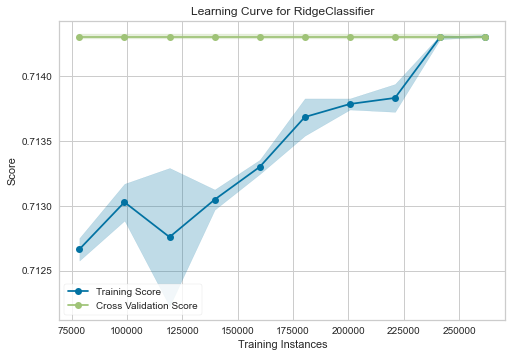

In [63]:
plot_model(estimator = tuned_RidgeClassifier, plot = 'learning')

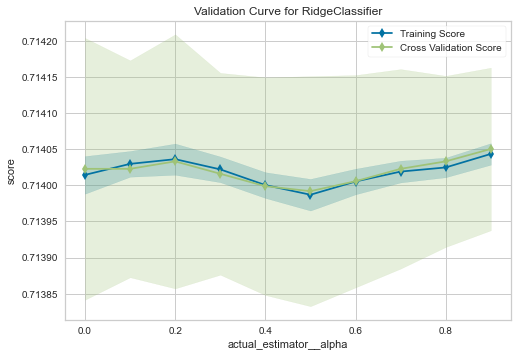

In [64]:
plot_model(estimator = tuned_RidgeClassifier, plot = 'vc')

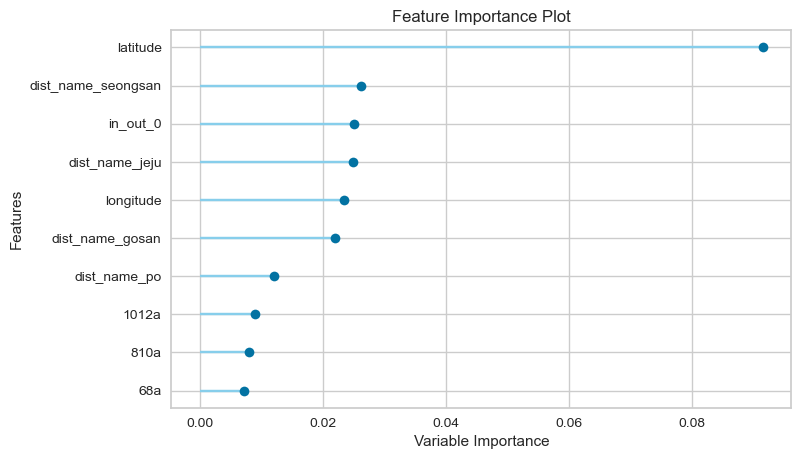

In [66]:
plot_model(estimator = tuned_RidgeClassifier, plot = 'feature')

In [67]:
plot_model(estimator = tuned_RidgeClassifier, plot = 'parameter')

,Parameters
alpha,7.27
class_weight,None
copy_X,True
fit_intercept,True
max_iter,None
normalize,True
random_state,3845
solver,auto
tol,0.001


In [68]:
evaluate_model(tuned_RidgeClassifier)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [69]:
test = X_test
RidgeClassifier_final = finalize_model(tuned_RidgeClassifier)
predict_model(RidgeClassifier_final,test)

,in_out,latitude,longitude,68a,810a,1012a,68b,810b,1012b,weekday_0,...,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan,Label
0,1,33.48990,126.49373,8.0,9.0,10.0,0.0,0.0,1.0,0,...,37.692766,37.713630,27.841879,23.009091,2.245455,0,1,0,0,0
1,1,33.48944,126.48508,7.0,7.0,19.0,0.0,0.0,0.0,0,...,37.008492,38.465822,27.996179,23.009091,2.245455,0,1,0,0,0
2,1,33.48181,126.47352,6.0,4.0,3.0,0.0,0.0,0.0,0,...,35.642126,39.259820,27.496551,23.009091,2.245455,0,1,0,0,0
3,0,33.50577,126.49252,12.0,26.0,46.0,0.0,0.0,0.0,0,...,38.643401,38.386802,29.579404,23.009091,2.245455,0,1,0,0,0
4,0,33.24872,126.41032,0.0,0.0,0.0,0.0,1.0,0.0,0,...,23.594010,46.355301,14.445605,22.518182,2.700000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,0,33.30073,126.18044,0.0,0.0,0.0,3.0,0.0,0.0,0,...,1.810388,65.835199,36.362254,NaN,NaN,1,0,0,0,0
228166,0,33.46262,126.33447,0.0,0.0,0.0,1.0,0.0,0.0,0,...,24.608845,51.446906,32.217732,NaN,NaN,0,1,0,0,0
228167,0,33.41437,126.26336,3.0,0.0,0.0,0.0,0.0,0.0,0,...,16.319339,57.465292,33.738981,NaN,NaN,1,0,0,0,0
228168,0,33.49946,126.51479,3.0,0.0,0.0,0.0,0.0,0.0,0,...,39.904297,36.202951,28.484278,NaN,NaN,0,1,0,0,0


In [70]:
LogisticRegression = create_model('lr')

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:40:25
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


KeyboardInterrupt: 

In [53]:
tuned_LogisticRegression = tune_model(LogisticRegression)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7143,0.0000,0.0116,0.5106,0.5955,0.0016,0.0173
1,0.7143,0.0000,0.0115,0.5105,0.5955,0.0013,0.0151
2,0.7143,0.0000,0.0118,0.5105,0.5954,0.0010,0.0136
3,0.7143,0.0000,0.0116,0.5106,0.5955,0.0016,0.0172
4,0.7143,0.0000,0.0115,0.5105,0.5955,0.0013,0.0149
5,0.7143,0.0000,0.0115,0.5105,0.5954,0.0011,0.0145
6,0.7143,0.0000,0.0118,0.5106,0.5955,0.0015,0.0165
7,0.7143,0.0000,0.0115,0.5201,0.5955,0.0015,0.0174
8,0.7143,0.0000,0.0115,0.5106,0.5955,0.0017,0.0180
9,0.7143,0.0000,0.0114,0.5105,0.5954,0.0011,0.0145


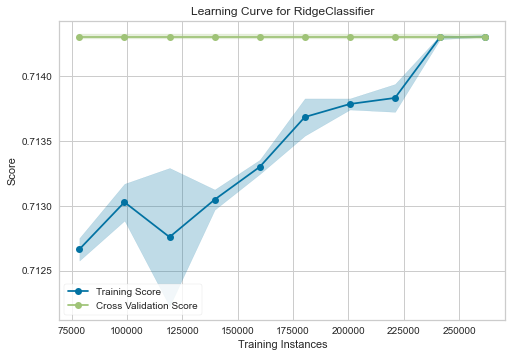

In [63]:
plot_model(estimator = tuned_LogisticRegression, plot = 'learning')

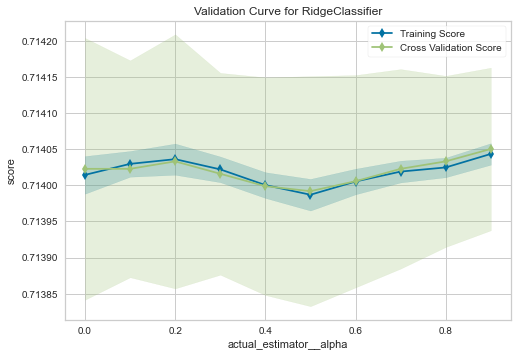

In [64]:
plot_model(estimator = tuned_LogisticRegression, plot = 'vc')

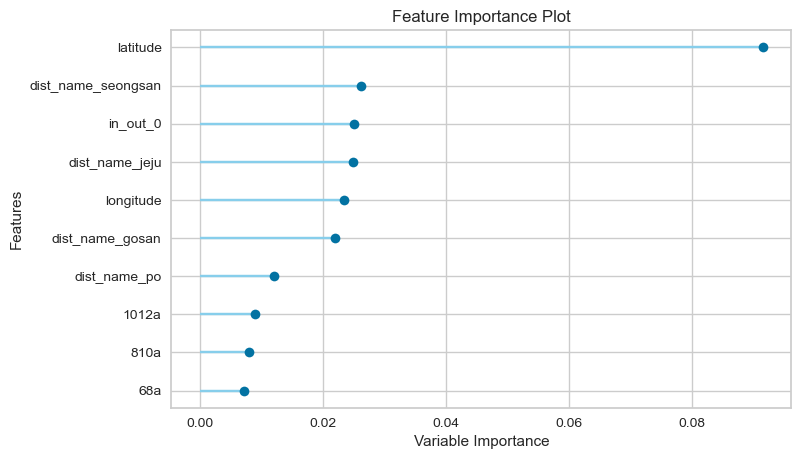

In [66]:
plot_model(estimator = tuned_LogisticRegression, plot = 'feature')

In [67]:
plot_model(estimator = tuned_LogisticRegression, plot = 'parameter')

,Parameters
alpha,7.27
class_weight,None
copy_X,True
fit_intercept,True
max_iter,None
normalize,True
random_state,3845
solver,auto
tol,0.001


In [68]:
evaluate_model(tuned_LogisticRegression)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [69]:
test = X_test
LogisticRegression_final = finalize_model(tuned_LogisticRegression)
predict_model(LogisticRegression_final,test)

,in_out,latitude,longitude,68a,810a,1012a,68b,810b,1012b,weekday_0,...,dis_gosan,dis_seongsan,dis_po,기온(°C),강수량(mm),dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan,Label
0,1,33.48990,126.49373,8.0,9.0,10.0,0.0,0.0,1.0,0,...,37.692766,37.713630,27.841879,23.009091,2.245455,0,1,0,0,0
1,1,33.48944,126.48508,7.0,7.0,19.0,0.0,0.0,0.0,0,...,37.008492,38.465822,27.996179,23.009091,2.245455,0,1,0,0,0
2,1,33.48181,126.47352,6.0,4.0,3.0,0.0,0.0,0.0,0,...,35.642126,39.259820,27.496551,23.009091,2.245455,0,1,0,0,0
3,0,33.50577,126.49252,12.0,26.0,46.0,0.0,0.0,0.0,0,...,38.643401,38.386802,29.579404,23.009091,2.245455,0,1,0,0,0
4,0,33.24872,126.41032,0.0,0.0,0.0,0.0,1.0,0.0,0,...,23.594010,46.355301,14.445605,22.518182,2.700000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,0,33.30073,126.18044,0.0,0.0,0.0,3.0,0.0,0.0,0,...,1.810388,65.835199,36.362254,NaN,NaN,1,0,0,0,0
228166,0,33.46262,126.33447,0.0,0.0,0.0,1.0,0.0,0.0,0,...,24.608845,51.446906,32.217732,NaN,NaN,0,1,0,0,0
228167,0,33.41437,126.26336,3.0,0.0,0.0,0.0,0.0,0.0,0,...,16.319339,57.465292,33.738981,NaN,NaN,1,0,0,0,0
228168,0,33.49946,126.51479,3.0,0.0,0.0,0.0,0.0,0.0,0,...,39.904297,36.202951,28.484278,NaN,NaN,0,1,0,0,0


In [ ]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

In [ ]:
pred_holdout = predict_model(blended)

In [ ]:
final_model = finalize_model(blended)

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    test_x[person_idx - 30000,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
test = pd.DataFrame(data=test_x)

In [ ]:
predictions = predict_model(final_model, data = test)

In [ ]:
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
    if predictions['Label'][i] =='1.0':
        x.append(predictions['Score'][i])
    else:
        x.append(1-predictions['Score'][i])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("AutoML.csv", index = False)